In [1]:
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

import folium
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
import requests
import pandas as pd

%matplotlib inline 

In [2]:
website_url = requests.get('https://www.governing.com/gov-data/population-density-land-area-cities-map.html').text
soup = BeautifulSoup(website_url,'lxml')

In [3]:
# get the table
my_table = soup.find("table", { "class":"dataTable"})

In [4]:
# convert BeautifulSoup tags to string list
def convert_to_list(bs4row):
    list_bs4row = bs4row.findAll(["td","th"])
    return [bs4.get_text().strip() for bs4 in list_bs4row]

In [5]:
# get the table 
rows=my_table.findAll("tr")

# first row is header
header = convert_to_list(rows[0])
# convert to list of list
my_data = [convert_to_list(r) for r in rows[1:]]

In [6]:
df = pd.DataFrame(my_data,columns=['City','Population_Density','Population','Land_Area'])

# convert the number from string to integer
for col in df.columns[1:]:
    df[col]=df[col].apply(lambda s: int(s.replace(',','')))
    
df.head()

,City,Population_Density,Population,Land_Area
0,"New York, New York",28211,8537673,303
1,"Los Angeles, California",8484,3976322,469
2,"Chicago, Illinois",11883,2704958,228
3,"Houston, Texas",3842,2303482,600
4,"Phoenix, Arizona",3126,1615017,517


In [7]:
df.describe()

,Population_Density,Population,Land_Area
count,754.000000,7.540000e+02,754.000000
mean,4242.729443,1.646172e+05,55.015915
std,4323.792554,3.973563e+05,95.695024
min,172.000000,5.007700e+04,1.000000
25%,2076.000000,6.417050e+04,19.000000
50%,3128.500000,8.669450e+04,31.500000
75%,4720.000000,1.380125e+05,54.750000
max,54138.000000,8.537673e+06,1705.000000


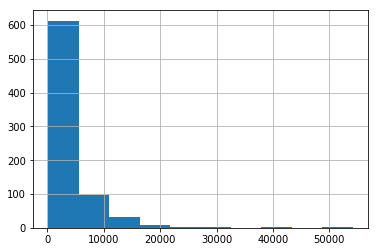

In [8]:
# Plot histogram of population density
df['Population_Density'].hist(bins=10)

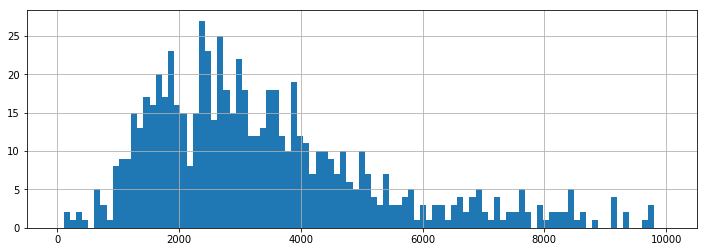

In [9]:
# Histogram of city with density less than 10,000
df['Population_Density'].hist(bins=np.linspace(0,10000,100),figsize=[12,4])

In [10]:
# Number of city with density > 6000
sum(df['Population_Density']>6000)

127

In [11]:
# Number of city with density < 2000
sum(df['Population_Density']<2000)

176

In [12]:
def set_density_class(density):
    if density>6000:
        return 1
    elif density<2000:
        return 0
    else:
        return np.NaN

In [13]:
df['Density_class'] = df['Population_Density'].apply(set_density_class)
df.dropna(subset=['Density_class'],inplace=True)

In [14]:
df_density_class = df[['City','Density_class']]

In [15]:
def get_latitude_longitude(city):
    geolocator = Nominatim(user_agent="my-application")
    try:
        location = geolocator.geocode(city)
        if location is not None:
            print(city)
            return location.latitude, location.longitude
        else:
            return np.NaN,np.NaN
    except GeocoderTimedOut:
        return get_latitude_longitude(city)

In [16]:
# Get the latitude and longitude for each city
df['Latitude'],df['Longitude'] = zip(*df['City'].apply(get_latitude_longitude))

# Remove city without latitude and longitude
df.dropna(subset=['Latitude', 'Longitude'], inplace=True)
df.shape

New York, New York
Los Angeles, California
Chicago, Illinois
Philadelphia, Pennsylvania
Jacksonville, Florida
San Francisco, California
Seattle, Washington
Washington, District of Columbia
Boston, Massachusetts
Nashville, Tennessee
Oklahoma City, Oklahoma
Louisville, Kentucky
Baltimore, Maryland
Milwaukee, Wisconsin
Kansas City, Missouri
Long Beach, California
Miami, Florida
Virginia Beach, Virginia
Oakland, California
Minneapolis, Minnesota
Anaheim, California
Santa Ana, California
Lexington, Kentucky
Anchorage, Alaska
Newark, New Jersey
Jersey City, New Jersey
Buffalo, New York
Scottsdale, Arizona
Winston-Salem, North Carolina
Chesapeake, Virginia
Hialeah, Florida
Birmingham, Alabama
Oxnard, California
Fayetteville, North Carolina
Glendale, California
Yonkers, New York
Huntington Beach, California
Montgomery, Alabama
Little Rock, Arkansas
Columbus, Georgia
Augusta-Richmond County, Georgia
Shreveport, Louisiana
Salt Lake City, Utah
Huntsville, Alabama
Mobile, Alabama
Tallahassee, Flor

(302, 7)

In [17]:
# @hidden_cell
CLIENT_ID = 'CRDS4XWDD4KPADKBVJP1JE5NW3AYATHVMUCCUC4ZFNIWNJZ5' # your Foursquare ID
CLIENT_SECRET = 'ZBKR4ETVK14UV2SMZRJ1OCPSLAZFF2K2RPBEWFEKWHFVFHTE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000,LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
df_city_venues = getNearbyVenues(df['City'],df['Latitude'],df['Longitude'])

New York, New York
Los Angeles, California
Chicago, Illinois
Philadelphia, Pennsylvania
Jacksonville, Florida
San Francisco, California
Seattle, Washington
Washington, District of Columbia
Boston, Massachusetts
Nashville, Tennessee
Oklahoma City, Oklahoma
Louisville, Kentucky
Baltimore, Maryland
Milwaukee, Wisconsin
Kansas City, Missouri
Long Beach, California
Miami, Florida
Virginia Beach, Virginia
Oakland, California
Minneapolis, Minnesota
Anaheim, California
Santa Ana, California
Lexington, Kentucky
Anchorage, Alaska
Newark, New Jersey
Jersey City, New Jersey
Buffalo, New York
Scottsdale, Arizona
Winston-Salem, North Carolina
Chesapeake, Virginia
Hialeah, Florida
Birmingham, Alabama
Oxnard, California
Fayetteville, North Carolina
Glendale, California
Yonkers, New York
Huntington Beach, California
Montgomery, Alabama
Little Rock, Arkansas
Columbus, Georgia
Augusta-Richmond County, Georgia
Shreveport, Louisiana
Salt Lake City, Utah
Huntsville, Alabama
Mobile, Alabama
Tallahassee, Flor

In [20]:
# one hot encoding of training set
df_onehot = pd.get_dummies(df_city_venues[['Venue Category']], prefix="", prefix_sep="")
df_onehot['City'] = df_city_venues['City']
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]
df_venues_freq_by_city = df_onehot.groupby('City').mean()

df_venues_freq_by_city_density = pd.merge(df_venues_freq_by_city, df_density_class, on=['City'], how='left')
df_venues_freq_by_city_density.head()

,City,ATM,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Service,American Restaurant,Amphitheater,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant,Zoo,Density_class
0,"Abilene, Texas",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,...,0.0,0.038462,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,"Albany, Georgia",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.120000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,"Alexandria, Virginia",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026316,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0
3,"Alhambra, California",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.013889,0.0,0.0,0.027778,0.0,0.000000,0.0,0.0,1.0
4,"Aliso Viejo, California",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026316,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.013158,0.0,0.0,1.0


### Decision Trees 
Build a model from Foursquare Venue Category data to predict the population density of the city

In [21]:
features = df_venues_freq_by_city_density.columns[1:-3]
X = df_venues_freq_by_city_density[features]
y = df_venues_freq_by_city_density['Density_class']

In [22]:
from sklearn.model_selection import train_test_split
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.9)

In [23]:
from sklearn.tree import DecisionTreeClassifier
cityTree = DecisionTreeClassifier(criterion="entropy")
cityTree.fit(X_trainset,y_trainset)
y_pred = cityTree.predict(X_testset)

In [24]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: {:.2f}".format(metrics.accuracy_score(y_testset, y_pred)))

DecisionTrees's Accuracy: 0.47


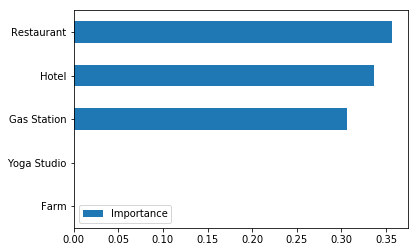

In [25]:
df_importance = pd.DataFrame({"Importance":cityTree.feature_importances_},index=features)
df_top10 = df_importance.sort_values(by=['Importance']).tail(5)
ax = df_top10.plot.barh(y='Importance')